<a href="https://colab.research.google.com/github/sydney-machine-learning/cyclonegenesis_seasurfacetemperature/blob/albert/Climate%20Project/albert/notebooks/Hierarchical_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q numpyro@git+https://github.com/pyro-ppl/numpyro

  Preparing metadata (setup.py) ... done


In [2]:
import os
# cpu cores available for sampling (we want this to equal num_chains)
os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=4'

from IPython.display import set_matplotlib_formats
import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import logsumexp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import arviz as az
import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS, Predictive

def get_saffir_simpson_category(wind_kn):
    # NOTE: observations are rounded to nearest 5 so is this being a bit cheeky??
    if wind_kn <= 82:
        return 1
    if wind_kn <= 95:
        return 2
    if wind_kn <= 112:
        return 3
    if wind_kn <= 136:
        return 4
    return 5

DATASET_URL = "https://raw.githubusercontent.com/sydney-machine-learning/cyclonegenesis_seasurfacetemperature/albert/Climate%20Project/albert/cyclone_data/jtwc/cleaned/full_instantaneous.csv"
dset = pd.read_csv(DATASET_URL)
# rename columns
dset.columns = dset.columns.str.replace(' ', '_').str.replace('(','').str.replace(')','').str.lower()
dset['category'] = dset['peak_vmax_kt'].apply(get_saffir_simpson_category)
dset

<ipython-input-2-74e8e88f4136>:36: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  dset.columns = dset.columns.str.replace(' ', '_').str.replace('(','').str.replace(')','').str.lower()
<ipython-input-2-74e8e88f4136>:36: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  dset.columns = dset.columns.str.replace(' ', '_').str.replace('(','').str.replace(')','').str.lower()


,timestamp,storm_id,basin,season,season_tc_number,stormname,latitude_degrees,longitude_degrees,vmax_kt,peak_vmax_kt,ace,maximum_24h_intensification,tropical_sst,global_sst,local_sst,local_month_mean,local_anomaly,saffir-simpson_category,category
0,1982-03-14 06:00:00,1982-N-1,WP,1982.0,1.0,NaN,7.1,153.0,15.0,60.0,0.73250,15.0,27.961514,13.499058,28.082220,28.562027,-0.479807,1,1
1,1981-10-21 06:00:00,1982-S-2,SI,1982.0,2.0,NaN,-8.0,84.6,40.0,85.0,1.18725,25.0,27.240122,13.386498,28.012896,27.828356,0.184540,2,2
2,1982-03-18 06:00:00,1982-N-2,WP,1982.0,2.0,NaN,3.8,160.7,25.0,105.0,2.02800,25.0,27.961514,13.499058,29.003502,28.968107,0.035395,3,3
3,1982-03-28 06:00:00,1982-N-3,WP,1982.0,3.0,NaN,3.5,156.6,20.0,75.0,0.70650,15.0,27.961514,13.499058,28.872086,29.140408,-0.268322,1,1
4,1981-12-05 00:00:00,1982-S-4,AUS,1982.0,4.0,NaN,-11.9,125.0,45.0,45.0,0.04850,-10.0,27.350914,13.314075,29.079239,30.004630,-0.925390,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1806,2022-10-14 06:00:00,2022-N-24,WP,2022.0,24.0,INVEST,26.4,154.4,25.0,40.0,0.19675,15.0,27.271444,13.853819,28.137896,27.757618,0.380278,1,1
1807,2022-10-26 00:00:00,2022-N-26,WP,2022.0,26.0,INVEST,12.2,133.8,20.0,75.0,0.67825,25.0,27.271444,13.853819,29.645842,29.207080,0.438761,1,1
1808,2022-10-28 12:00:00,2022-N-27,WP,2022.0,27.0,INVEST,8.0,140.4,25.0,40.0,0.10875,15.0,27.271444,13.853819,29.821840,29.312254,0.509586,1,1
1809,2022-11-11 18:00:00,2022-N-28,WP,2022.0,28.0,INVEST,20.2,166.3,20.0,40.0,0.10600,10.0,27.478075,13.700613,28.148760,27.703903,0.444857,1,1


In [3]:
standardize = lambda x: (x - x.mean()) / x.std()

BASIN_TO_INDEX = {
    'AUS': 0,
    'SI' : 1,
    'SP' : 2,
    'WP' : 3,
}

## FOR NUMERICAL STABILITY
dset["tropical_sst_scaled"] = dset.tropical_sst.pipe(standardize)
dset["local_sst_scaled"] = dset.local_sst.pipe(standardize)
dset["peak_wind_scaled"] = dset.peak_vmax_kt.pipe(lambda x: standardize(x))
dset['basin_numerical'] = dset.basin.apply(lambda x: BASIN_TO_INDEX[x])
dset

,timestamp,storm_id,basin,season,season_tc_number,stormname,latitude_degrees,longitude_degrees,vmax_kt,peak_vmax_kt,...,global_sst,local_sst,local_month_mean,local_anomaly,saffir-simpson_category,category,tropical_sst_scaled,local_sst_scaled,peak_wind_scaled,basin_numerical
0,1982-03-14 06:00:00,1982-N-1,WP,1982.0,1.0,NaN,7.1,153.0,15.0,60.0,...,13.499058,28.082220,28.562027,-0.479807,1,1,0.716901,-1.405316,-0.704706,3
1,1981-10-21 06:00:00,1982-S-2,SI,1982.0,2.0,NaN,-8.0,84.6,40.0,85.0,...,13.386498,28.012896,27.828356,0.184540,2,2,-0.677591,-1.515175,0.041553,1
2,1982-03-18 06:00:00,1982-N-2,WP,1982.0,2.0,NaN,3.8,160.7,25.0,105.0,...,13.499058,29.003502,28.968107,0.035395,3,3,0.716901,0.054655,0.638561,3
3,1982-03-28 06:00:00,1982-N-3,WP,1982.0,3.0,NaN,3.5,156.6,20.0,75.0,...,13.499058,28.872086,29.140408,-0.268322,1,1,0.716901,-0.153602,-0.256951,3
4,1981-12-05 00:00:00,1982-S-4,AUS,1982.0,4.0,NaN,-11.9,125.0,45.0,45.0,...,13.314075,29.079239,30.004630,-0.925390,1,1,-0.463423,0.174677,-1.152462,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1806,2022-10-14 06:00:00,2022-N-24,WP,2022.0,24.0,INVEST,26.4,154.4,25.0,40.0,...,13.853819,28.137896,27.757618,0.380278,1,1,-0.617043,-1.317085,-1.301714,3
1807,2022-10-26 00:00:00,2022-N-26,WP,2022.0,26.0,INVEST,12.2,133.8,20.0,75.0,...,13.853819,29.645842,29.207080,0.438761,1,1,-0.617043,1.072582,-0.256951,3
1808,2022-10-28 12:00:00,2022-N-27,WP,2022.0,27.0,INVEST,8.0,140.4,25.0,40.0,...,13.853819,29.821840,29.312254,0.509586,1,1,-0.617043,1.351489,-1.301714,3
1809,2022-11-11 18:00:00,2022-N-28,WP,2022.0,28.0,INVEST,20.2,166.3,20.0,40.0,...,13.700613,28.148760,27.703903,0.444857,1,1,-0.217614,-1.299869,-1.301714,3


In [4]:
NUM_BASINS = 4

## TODO: NEEED LONGER CHAINS.....
# https://betanalpha.github.io/assets/case_studies/divergences_and_bias.html

def centred_hierarchical(
    tropical_sst=None, local_sst=None,
    peak_wind=None, basin_num=None, q=None):

    ## TODO... choice of prior for each quantile
    μ_α = numpyro.sample("μ_α", dist.Normal(np.quantile(peak_wind, q), 0.1))
    σ_α = numpyro.sample("σ_α", dist.HalfCauchy(1))

    μ_β_trop = numpyro.sample("μ_β_trop", dist.Normal(0.0, 5.0))
    σ_β_trop = numpyro.sample("σ_β_trop", dist.HalfCauchy(5))

    μ_β_local = numpyro.sample("μ_β_local", dist.Normal(0.0, 5.0))
    σ_β_local = numpyro.sample("σ_β_local", dist.HalfCauchy(5))

    with numpyro.plate("basins", NUM_BASINS):
        α = numpyro.sample("α", dist.Normal(μ_α, σ_α))
        β_trop = numpyro.sample("β_trop", dist.Normal(μ_β_trop, σ_β_trop))
        β_local = numpyro.sample("β_local", dist.Normal(μ_β_local, σ_β_local))

        assert α.shape == (NUM_BASINS, ), "alpha shape wrong"

    mu = numpyro.deterministic('mu', α[basin_num] +  β_trop[basin_num] * tropical_sst + β_local[basin_num] * local_sst)
    return numpyro.sample('obs', dist.AsymmetricLaplaceQuantile(loc=mu, scale=1.0,quantile=q), obs=peak_wind)


from numpyro.handlers import reparam
from numpyro.infer.reparam import LocScaleReparam

## try the numpyro reparametrisation as well
reparam_config = {
    "α": LocScaleReparam(0),
    "β_trop": LocScaleReparam(0),
    "β_local": LocScaleReparam(0),
}

reparamed_hierarchical = reparam(
    centred_hierarchical, config=reparam_config)


def noncentred_hierarchical(
    tropical_sst=None, local_sst=None,
    peak_wind=None, basin_num=None, q=None):

    ## TODO... choice of prior for hierarchical model??
    μ_α = numpyro.sample("μ_α", dist.Normal(np.quantile(peak_wind, q), 0.1))
    σ_α = numpyro.sample("σ_α", dist.HalfCauchy(1))

    μ_β_trop = numpyro.sample("μ_β_trop", dist.Normal(0.0, 0.1))
    σ_β_trop = numpyro.sample("σ_β_trop", dist.HalfCauchy(1))

    μ_β_local = numpyro.sample("μ_β_local", dist.Normal(0.0, 0.1))
    σ_β_local = numpyro.sample("σ_β_local", dist.HalfCauchy(1))

    with numpyro.plate("basins", NUM_BASINS):
        α_prime = numpyro.sample("α_prime", dist.Normal(0, 1))
        α = numpyro.deterministic('α', α_prime * σ_α + μ_α)

        β_trop_prime = numpyro.sample("β_trop_prime", dist.Normal(0,1))
        β_trop = numpyro.deterministic('β_trop', β_trop_prime* σ_β_trop + μ_β_trop)


        β_local_prime = numpyro.sample("β_local_prime", dist.Normal(0,1))
        β_local = numpyro.deterministic('β_local', β_local_prime* σ_β_local + μ_β_local)

        assert α.shape == (NUM_BASINS, ), "alpha shape wrong"

    mu = numpyro.deterministic('mu', α[basin_num] +  β_trop[basin_num] * tropical_sst + β_local[basin_num] * local_sst)
    return numpyro.sample('obs', dist.AsymmetricLaplaceQuantile(loc=mu, scale=1.0,quantile=q), obs=peak_wind)


In [24]:
rng_key = random.PRNGKey(0)
qs = np.round(np.arange(0.05, 0.96, 0.1), 2)
params = {}

numpyro.enable_x64()

### ADAPT DELTA FOR A HIERARCHICAL MODEL????

for q in qs:
    rng_key, rng_key_ = random.split(rng_key)
    kernel = NUTS(noncentred_hierarchical)
    mcmc = MCMC(kernel, num_chains=4, num_warmup=1000, num_samples=10000, progress_bar=True)
    mcmc.run(
        rng_key_,
        tropical_sst=dset.tropical_sst_scaled.values,
        local_sst=dset.local_sst_scaled.values,
        peak_wind=dset.peak_wind_scaled.values,
        basin_num=dset.basin_numerical.values,
        q=q )
    mcmc_samples = mcmc.get_samples()
    params[q] = mcmc_samples
    print(q)
    mcmc.print_summary()
    print()

    # posterior_predictive = Predictive(
    #     noncentred_hierarchical, posterior_samples=mcmc_samples,
    #     # return_sites=extract_vars
    # )(rng_key_,
    #   tropical_sst = dset.tropical_sst_scaled.values,
    #   local_sst    = dset.local_sst_scaled.values,
    #   peak_wind    = dset.peak_wind_scaled.values,
    #   basin_num=dset.basin_numerical.values,
    #   q            = q
    # )

    arviz_posterior = az.from_numpyro(
            mcmc,
            # posterior_predictive=posterior_predictive,
            # coords=az_coords,
            # dims=az_dims
    )

    params[q] = arviz_posterior
    print(q)
    mcmc.print_summary()
    print()

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

0.05

                      mean       std    median      5.0%     95.0%     n_eff     r_hat
      α_prime[0]      0.00      0.87      0.01     -1.44      1.43  28248.77      1.00
      α_prime[1]      0.12      0.90      0.13     -1.34      1.63  32118.94      1.00
      α_prime[2]     -0.03      0.88     -0.02     -1.46      1.44  30192.09      1.00
      α_prime[3]      0.04      0.83      0.05     -1.30      1.45  23933.69      1.00
β_local_prime[0]     -0.12      0.85     -0.12     -1.48      1.31  25397.42      1.00
β_local_prime[1]     -0.02      0.87     -0.02     -1.45      1.44  30628.41      1.00
β_local_prime[2]      0.06      0.91      0.06     -1.45      1.55  29433.65      1.00
β_local_prime[3]      0.12      0.83      0.11     -1.22      1.55  24378.66      1.00
 β_trop_prime[0]     -0.04      0.87     -0.04     -1.46      1.41  27320.85      1.00
 β_trop_prime[1]     -0.00      0.88     -0.00     -1.45      1.44  28265.09      1.00
 β_trop_prime[2]     -0.03      0.90 

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

0.15

                      mean       std    median      5.0%     95.0%     n_eff     r_hat
      α_prime[0]     -0.11      0.84     -0.11     -1.53      1.24  23003.06      1.00
      α_prime[1]      0.15      0.88      0.16     -1.32      1.59  23073.97      1.00
      α_prime[2]      0.02      0.89      0.03     -1.44      1.48  27935.07      1.00
      α_prime[3]      0.19      0.83      0.20     -1.15      1.60  22223.54      1.00
β_local_prime[0]     -0.24      0.83     -0.23     -1.61      1.12  22789.99      1.00
β_local_prime[1]      0.01      0.85      0.02     -1.45      1.37  23130.74      1.00
β_local_prime[2]      0.17      0.89      0.17     -1.26      1.68  26391.28      1.00
β_local_prime[3]      0.22      0.84      0.22     -1.16      1.62  21939.36      1.00
 β_trop_prime[0]      0.09      0.85      0.09     -1.31      1.48  27688.34      1.00
 β_trop_prime[1]     -0.06      0.86     -0.06     -1.47      1.37  25398.62      1.00
 β_trop_prime[2]      0.03      0.88 

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

0.25

                      mean       std    median      5.0%     95.0%     n_eff     r_hat
      α_prime[0]     -0.44      0.83     -0.44     -1.85      0.89  24642.76      1.00
      α_prime[1]      0.01      0.86     -0.00     -1.41      1.43  25436.89      1.00
      α_prime[2]     -0.02      0.85     -0.02     -1.41      1.41  26065.84      1.00
      α_prime[3]      0.24      0.80      0.22     -1.08      1.55  21600.34      1.00
β_local_prime[0]     -0.51      0.75     -0.48     -1.77      0.70  19400.68      1.00
β_local_prime[1]      0.02      0.80      0.04     -1.30      1.33  25825.78      1.00
β_local_prime[2]      0.40      0.83      0.42     -1.02      1.73  26757.29      1.00
β_local_prime[3]      0.41      0.75      0.40     -0.81      1.66  23708.49      1.00
 β_trop_prime[0]      0.15      0.86      0.15     -1.28      1.54  24132.65      1.00
 β_trop_prime[1]     -0.10      0.87     -0.11     -1.53      1.35  26984.43      1.00
 β_trop_prime[2]     -0.01      0.87 

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

0.35

                      mean       std    median      5.0%     95.0%     n_eff     r_hat
      α_prime[0]     -0.66      0.68     -0.62     -1.79      0.41  22966.59      1.00
      α_prime[1]      0.08      0.73      0.09     -1.09      1.29  28882.73      1.00
      α_prime[2]     -0.05      0.71     -0.04     -1.20      1.10  28606.58      1.00
      α_prime[3]      0.82      0.67      0.78     -0.20      1.96  22547.20      1.00
β_local_prime[0]     -0.56      0.70     -0.51     -1.76      0.51  21536.30      1.00
β_local_prime[1]     -0.03      0.74     -0.02     -1.25      1.21  28324.41      1.00
β_local_prime[2]      0.65      0.77      0.65     -0.59      1.93  27516.78      1.00
β_local_prime[3]      0.48      0.69      0.46     -0.65      1.62  21837.57      1.00
 β_trop_prime[0]      0.25      0.83      0.25     -1.14      1.61  27091.83      1.00
 β_trop_prime[1]     -0.10      0.87     -0.10     -1.47      1.41  32573.02      1.00
 β_trop_prime[2]     -0.12      0.88 

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

0.45

                      mean       std    median      5.0%     95.0%     n_eff     r_hat
      α_prime[0]     -0.85      0.60     -0.79     -1.86      0.04  21051.55      1.00
      α_prime[1]     -0.01      0.64     -0.01     -1.07      1.04  25909.95      1.00
      α_prime[2]     -0.16      0.62     -0.15     -1.21      0.84  24281.88      1.00
      α_prime[3]      0.94      0.60      0.86      0.00      1.88  17698.29      1.00
β_local_prime[0]     -0.55      0.66     -0.48     -1.66      0.44  20454.22      1.00
β_local_prime[1]      0.02      0.70      0.04     -1.17      1.12  23685.62      1.00
β_local_prime[2]      0.79      0.76      0.79     -0.39      2.07  25676.74      1.00
β_local_prime[3]      0.57      0.61      0.53     -0.37      1.61  21494.46      1.00
 β_trop_prime[0]      0.32      0.83      0.33     -1.03      1.71  25765.86      1.00
 β_trop_prime[1]     -0.07      0.85     -0.07     -1.52      1.30  31446.57      1.00
 β_trop_prime[2]     -0.17      0.89 

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

0.55

                      mean       std    median      5.0%     95.0%     n_eff     r_hat
      α_prime[0]     -1.10      0.57     -1.04     -1.99     -0.18  21763.36      1.00
      α_prime[1]     -0.13      0.60     -0.14     -1.13      0.86  24453.07      1.00
      α_prime[2]     -0.40      0.57     -0.38     -1.34      0.51  23583.06      1.00
      α_prime[3]      0.69      0.54      0.61     -0.08      1.61  15214.64      1.00
β_local_prime[0]     -0.48      0.63     -0.40     -1.50      0.50  18114.43      1.00
β_local_prime[1]      0.16      0.67      0.18     -0.95      1.26  24566.50      1.00
β_local_prime[2]      0.98      0.71      0.97     -0.11      2.18  23303.82      1.00
β_local_prime[3]      0.47      0.58      0.44     -0.41      1.44  20503.61      1.00
 β_trop_prime[0]      0.51      0.82      0.53     -0.82      1.87  25248.25      1.00
 β_trop_prime[1]     -0.04      0.82     -0.03     -1.39      1.32  25660.50      1.00
 β_trop_prime[2]     -0.36      0.83 

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

0.65

                      mean       std    median      5.0%     95.0%     n_eff     r_hat
      α_prime[0]     -0.89      0.56     -0.83     -1.79     -0.02  21018.29      1.00
      α_prime[1]      0.20      0.60      0.19     -0.78      1.20  23862.05      1.00
      α_prime[2]     -0.35      0.57     -0.32     -1.27      0.60  21853.77      1.00
      α_prime[3]      0.97      0.55      0.90      0.10      1.80  16296.55      1.00
β_local_prime[0]     -0.52      0.59     -0.44     -1.51      0.36  19638.46      1.00
β_local_prime[1]      0.18      0.65      0.19     -0.89      1.23  23487.18      1.00
β_local_prime[2]      1.06      0.67      1.03      0.03      2.19  22638.97      1.00
β_local_prime[3]      0.45      0.55      0.42     -0.45      1.33  23702.64      1.00
 β_trop_prime[0]      0.82      0.69      0.80     -0.19      2.02  22704.45      1.00
 β_trop_prime[1]      0.14      0.69      0.17     -0.98      1.30  23584.77      1.00
 β_trop_prime[2]     -0.57      0.71 

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

0.75

                      mean       std    median      5.0%     95.0%     n_eff     r_hat
      α_prime[0]     -1.13      0.54     -1.08     -1.97     -0.29  18664.39      1.00
      α_prime[1]     -0.22      0.50     -0.21     -1.06      0.58  21270.55      1.00
      α_prime[2]     -0.79      0.50     -0.74     -1.60     -0.01  22328.60      1.00
      α_prime[3]      0.55      0.47      0.46     -0.13      1.31  14536.16      1.00
β_local_prime[0]     -0.61      0.62     -0.53     -1.66      0.30  17661.30      1.00
β_local_prime[1]      0.32      0.60      0.32     -0.63      1.33  21638.56      1.00
β_local_prime[2]      0.98      0.70      0.96     -0.04      2.21  21839.03      1.00
β_local_prime[3]      0.45      0.55      0.42     -0.37      1.40  19209.10      1.00
 β_trop_prime[0]      0.86      0.71      0.85     -0.18      2.11  21313.15      1.00
 β_trop_prime[1]      0.06      0.68      0.08     -1.04      1.18  25467.66      1.00
 β_trop_prime[2]     -0.60      0.70 

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

0.85

                      mean       std    median      5.0%     95.0%     n_eff     r_hat
      α_prime[0]     -0.84      0.54     -0.79     -1.71     -0.01  21684.64      1.00
      α_prime[1]     -0.30      0.54     -0.29     -1.16      0.60  23141.15      1.00
      α_prime[2]     -0.65      0.56     -0.61     -1.60      0.22  23362.24      1.00
      α_prime[3]      0.90      0.56      0.81      0.06      1.76  14814.15      1.00
β_local_prime[0]     -0.43      0.69     -0.37     -1.65      0.58  25157.34      1.00
β_local_prime[1]      0.25      0.73      0.25     -0.94      1.47  25118.28      1.00
β_local_prime[2]      0.78      0.84      0.81     -0.60      2.16  23750.86      1.00
β_local_prime[3]      0.36      0.64      0.34     -0.64      1.47  21906.55      1.00
 β_trop_prime[0]      0.54      0.85      0.57     -0.85      1.95  23936.37      1.00
 β_trop_prime[1]     -0.06      0.81     -0.05     -1.39      1.29  30423.13      1.00
 β_trop_prime[2]     -0.21      0.85 

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

0.95

                      mean       std    median      5.0%     95.0%     n_eff     r_hat
      α_prime[0]     -0.68      0.68     -0.65     -1.82      0.41  24952.52      1.00
      α_prime[1]     -0.32      0.68     -0.31     -1.42      0.81  29603.08      1.00
      α_prime[2]     -0.29      0.70     -0.28     -1.45      0.86  28214.18      1.00
      α_prime[3]      0.85      0.61      0.77     -0.06      1.85  18383.79      1.00
β_local_prime[0]     -0.11      0.83     -0.09     -1.46      1.30  32124.39      1.00
β_local_prime[1]      0.10      0.85      0.11     -1.33      1.50  27434.90      1.00
β_local_prime[2]      0.29      0.92      0.32     -1.21      1.82  32414.31      1.00
β_local_prime[3]      0.29      0.77      0.30     -0.97      1.61  18683.12      1.00
 β_trop_prime[0]      0.17      0.85      0.18     -1.21      1.59  30754.82      1.00
 β_trop_prime[1]      0.04      0.86      0.05     -1.41      1.41  31147.61      1.00
 β_trop_prime[2]      0.06      0.88 

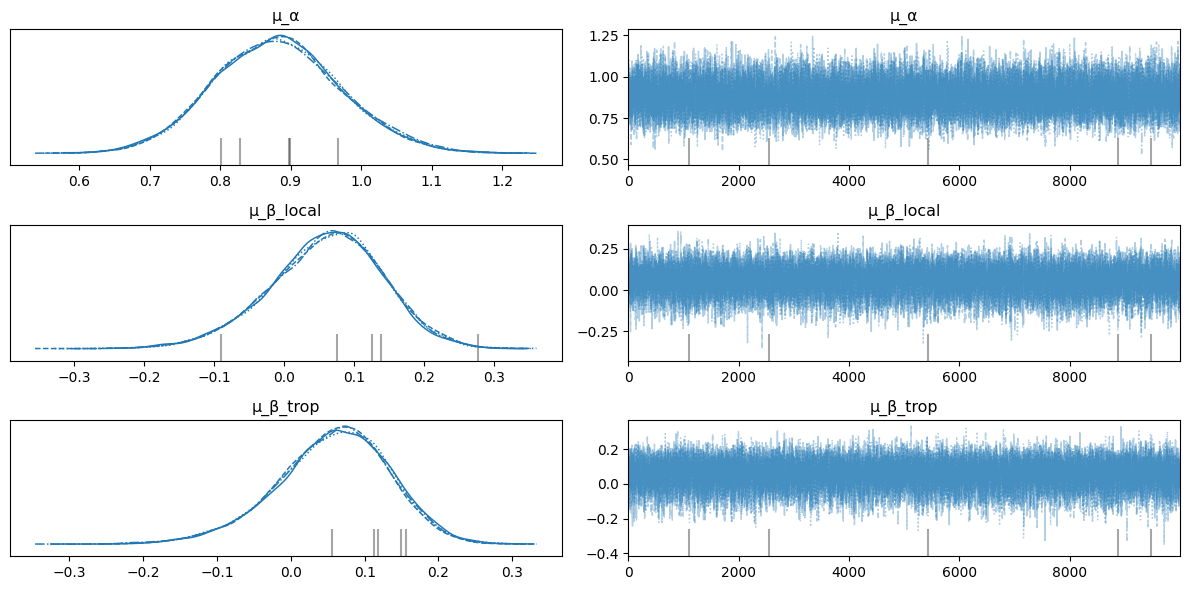

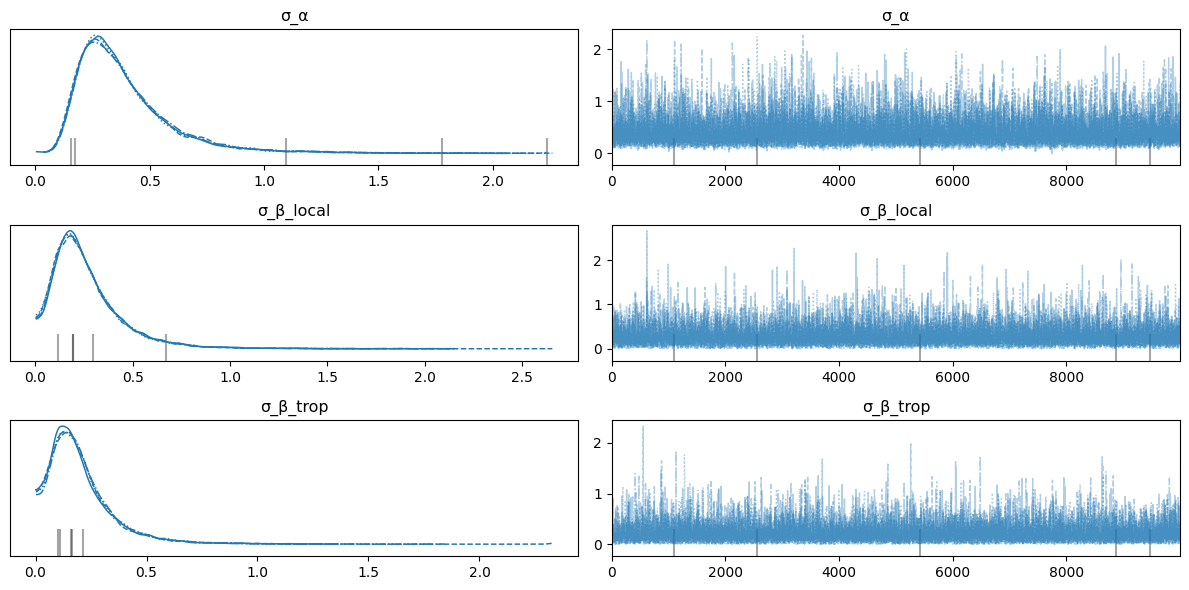

In [25]:
CHOSEN_QUANTILE = 0.75


az.plot_trace(params[CHOSEN_QUANTILE], var_names=['μ_α', 'μ_β_local', 'μ_β_trop']);
plt.tight_layout()
plt.show()

az.plot_trace(params[CHOSEN_QUANTILE], var_names=['σ_α', 'σ_β_local', 'σ_β_trop']);
plt.tight_layout()
plt.show()

## The 'Funnel' distribution and associated problems.

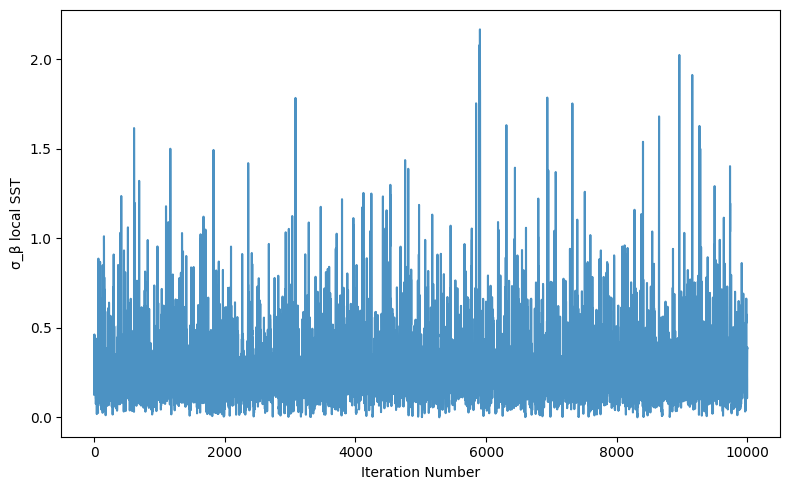

In [26]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(params[CHOSEN_QUANTILE]['posterior']['σ_β_local'].sel(chain=3).to_series(), alpha=.8);
ax.set_ylabel('σ_β local SST')
ax.set_xlabel('Iteration Number')
fig.tight_layout()
fig.savefig('./sigma_local_chain_noncentred.png')
plt.show()


            β Local SST AUS  σ β(Local SST)  divergent
chain draw                                            
0     0           -0.018609       -1.659043      False
      1           -0.040607       -0.770548      False
      2           -0.023283       -1.373207      False
      3           -0.058211       -1.270198      False
      4           -0.094026       -1.420646      False
...                     ...             ...        ...
3     9995        -0.007615       -2.234501      False
      9996        -0.137212       -1.470050      False
      9997        -0.131062       -1.267961      False
      9998        -0.205049       -0.939177      False
      9999        -0.214006       -0.951672      False

[40000 rows x 3 columns]


<ipython-input-28-28c554a9e4d4>:12: UserWarning: Ignoring `ax`; jointplot is a figure-level function.
  g = sns.jointplot(data = df, x=x_label, y=y_label, hue='divergent', ax=ax);


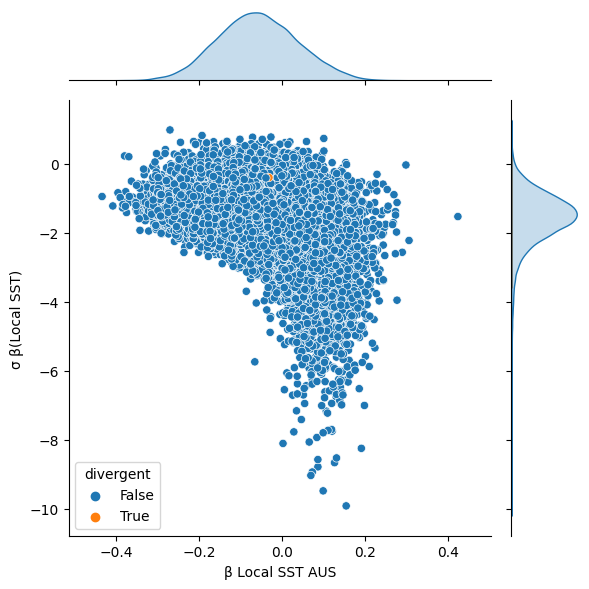

In [28]:
### PLOT DIVERGENT TRANSITIONS.....
x = params[CHOSEN_QUANTILE]['posterior']['β_local'].sel(β_local_dim_0=0).to_series()
y = params[CHOSEN_QUANTILE]['posterior']['σ_β_local'].to_series()
is_div = params[CHOSEN_QUANTILE]['sample_stats']['diverging'].to_series()

x_label = 'β Local SST AUS'
y_label = 'σ β(Local SST)'

df = pd.DataFrame({x_label: x, y_label: np.log(y), 'divergent': is_div})
print(df)

g = sns.jointplot(data = df, x=x_label, y=y_label, hue='divergent', ax=ax);
# g.set_axis_labels('β for Tropical SST, SP Basin', 'σ_β Tropical SST', fontsize=16)

g.figure.tight_layout()
g.figure.savefig('./sigma_beta_pairplot_noncentred.png')
plt.show()



In [9]:
arviz_posterior

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

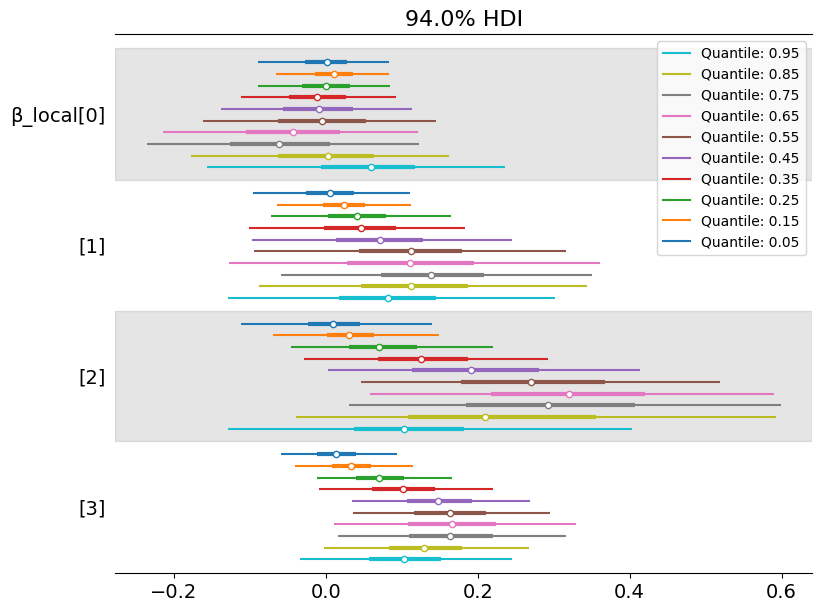

In [46]:


posteriors = [params[q]['posterior']['β_local'].assign_coords({
    'β_local_dim_0':
}) for q in qs]



az.plot_forest(posteriors,
                model_names = [f'Quantile: {q}' for q in qs],
                           kind='forestplot',
                           combined=True,
                           figsize=(9, 7))

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

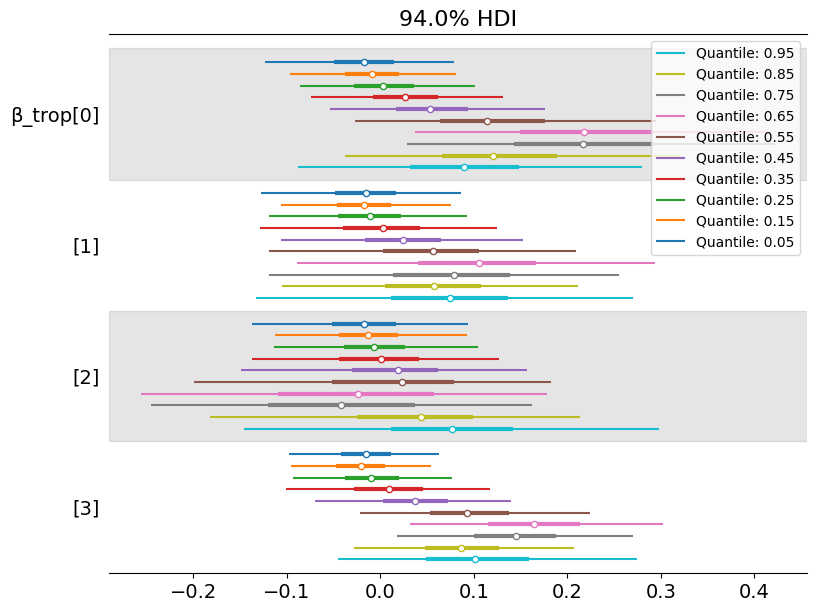

In [47]:
az.plot_forest([params[q]['posterior']['β_trop'] for q in qs],
                model_names = [f'Quantile: {q}' for q in qs],
                           kind='forestplot',
                           combined=True,
                           figsize=(9, 7))

In [39]:
az.load_arviz_data('non_centered_eight')

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

## Local SST Coefficients across the basins

        chain  draw  β_local_dim_0   β_local Basin
0           0     0              0 -0.017662   AUS
1           0     0              1  0.231785    SI
2           0     0              2  0.351600    SP
3           0     0              3  0.240564    WP
4           0     1              0 -0.084255   AUS
...       ...   ...            ...       ...   ...
159995      3  9998              3  0.160674    WP
159996      3  9999              0  0.125661   AUS
159997      3  9999              1 -0.046549    SI
159998      3  9999              2  0.208069    SP
159999      3  9999              3  0.085497    WP

[160000 rows x 5 columns]


<Axes: xlabel='Basin', ylabel='β_local'>

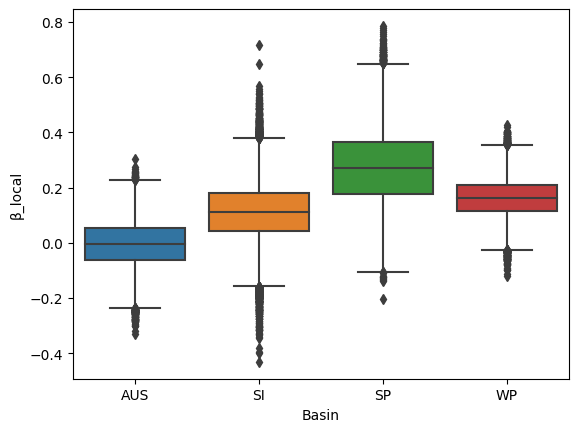

In [29]:
# # import matplotlib.pyplot as plt
# # fig, axs = plt.subplots(nrows=len(qs), ncols=1, figsize=(8,8))


# INDEX_TO_BASIN = ['AUS', 'SI', 'SP', 'WP']
# coeff_series = params[0.55]["posterior"]["β_local"].to_series().reset_index()
# coeff_series['Basin'] = coeff_series["β_local_dim_0"].apply(lambda x: INDEX_TO_BASIN[x])
# print(coeff_series)
# sns.boxplot(data=coeff_series, y="β_local", x="Basin")

# # for q_index in range(len(qs)):
# #   curr_quantile = qs[q_index]
# #   print(curr_quantile)
# #   coeff_series = params[curr_quantile]["posterior"]["β_local"].to_series().reset_index()
# #   print(coeff_series)
# #   sns.boxplot(data=coeff_series, x="β_local", hue="β_local_dim_0",  ax=axs[q_index])